In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
import seaborn as sns

from projectwind.data import get_data
from projectwind.clean import clean_timesteps

from sklearn import set_config; set_config(display='diagram')

# LSTM_data.py

In [ ]:
data = get_data(25)

In [ ]:
data = clean_timesteps(data)

In [ ]:
save = data.copy()

## Quick check on number of NaN over the period

In [ ]:
# Count number of na
isna_df = data[0].isna().sum(axis=1) / len(data[0].columns)

# Resample on daily basis
daily_data = isna_df.resample('D').sum() / 6 # divide by # periods to get ~ 24hr % missing values

# Graph output
fig, ax = plt.subplots(figsize=(20,5))
plt.bar(x=daily_data.index, height=daily_data.values);

In [ ]:
# Good to see there are less missing values towards end of data 
# (meaning test and validation sets should be of better quality than train set)

## Data engineering

### Interpolate all NaNs

In [ ]:
from projectwind.LSTM_preproc import clean_LSTM_data

In [ ]:
full_data = clean_LSTM_data(data)

### Create wind speed & direction vectors and misalignment to average wind farm vector

In [ ]:
# Average wind speeds & directions over the wind turbines
wind_speeds = pd.DataFrame()
nacelle_dir = pd.DataFrame()
misalignment = pd.DataFrame()
for idx, WTG_data in enumerate(data):
    wind_speeds[idx] = WTG_data['Wind Speed']
    nacelle_dir[idx] = WTG_data['Nacelle Orientation']
    misalignment[idx] = WTG_data['Misalignment']

In [ ]:
for idx in misalignment:
    misalignment[idx] = misalignment[idx].apply(lambda x: x if x <=180 else (360 - x)*-1)

In [ ]:
wind_dir = pd.DataFrame()
for idx in misalignment:
    wind_dir[idx] = nacelle_dir[idx] - misalignment[idx]

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i in range(len(nacelle_dir.columns)):
    row, col = i//5, i%5
    axes[row,col].hist2d(wind_dir[i], wind_speeds[i], bins=(50, 50), vmax=400)
    plt.xlabel('Wind Direction [deg]')
    plt.ylabel('Wind Velocity [m/s]');
plt.tight_layout()

In [ ]:
wind_X_vector = pd.DataFrame()
wind_Y_vector = pd.DataFrame()
for idx in wind_dir:
    wind_dir[idx] = wind_dir[idx] * np.pi / 180 # convert to radians
    wind_X_vector[idx] = wind_speeds[idx] * np.cos(wind_dir[idx])  # get X vector
    wind_Y_vector[idx] = wind_speeds[idx] * np.sin(wind_dir[idx])  # get Y vector

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i in range(len(nacelle_dir.columns)):
    row, col = i//5, i%5
    axes[row,col].hist2d(wind_X_vector[i], wind_Y_vector[i], bins=(50, 50), vmax=400)
    plt.xlabel('Wind X [m/s]')
    plt.ylabel('Wind Y [m/s]');
plt.tight_layout()

In [ ]:
for idx, WTG_data in enumerate(data):
    WTG_data['WTG_wind_X'] = wind_X_vector[idx]
    WTG_data['WTG_wind_Y'] = wind_Y_vector[idx]
#     WTG_data['Misalign_wind_X'] = average['X_vector'] - wind_X_vector[idx] # Creates data leakage!
#     WTG_data['Misalign_wind_Y'] = average['Y_vector'] - wind_Y_vector[idx] # Creates data leakage!
    WTG_data.drop(columns=['Misalignment','Nacelle Orientation'], inplace=True)

### Power vs. Rotor Speed check

In [ ]:
temp = data[19].loc['2020-03-05':'2020-03-06']

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
sns.lineplot(x=temp.index, y=temp['Power']/150)
sns.lineplot(x=temp.index, y=temp['Rotor Speed'])
sns.lineplot(x=temp.index, y=temp['Wind Speed'])
fig.legend(['Power','Rotor Speed', 'Wind Speed']);

### Sine/Cosine Time

In [ ]:
df = pd.DataFrame(index=data[0].index)
timestamp_s = data[0].index.map(pd.Timestamp.timestamp)

day = 24*60*60

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))

In [ ]:
plt.plot(df.iloc[0:792,0])
plt.plot(df.iloc[0:792,1]);

In [ ]:
for WTG_data in data:
    WTG_data['Day sin'] = df['Day sin']
    WTG_data['Day cos'] = df['Day cos']

## Split the data

In [ ]:
df = data[0]
df.head()

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data Windowing

In [ ]:
import tensorflow as tf

In [ ]:
df.head()

### Example

In [ ]:
data[2]

In [ ]:
df.columns

In [ ]:
w1 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=df.columns)
w1

In [ ]:
w2 = WindowGenerator(input_width=24*5*6, label_width=12*6, shift=12*6,
                     label_columns=['Power'])
w2

In [ ]:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

In [ ]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

In [ ]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

In [ ]:
for i in w2.train.take(25):
    print(i)

In [ ]:
for example_inputs, example_labels in w2.train.take(100):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

In [ ]:
dataset = w2.train.take(1)

In [ ]:
for sequence in dataset:
    sequence.plot()

# TEST

In [3]:
from projectwind.LSTM_data import WindowGenerator, get_LSTM_data

In [4]:
train_df, val_df, test_df = get_LSTM_data(2)

/home/shmiggit/code/AmaurySalles/projectwind/raw_data
1
2


In [5]:
train_df = train_df[0]
val_df = val_df[0]
test_df = test_df[0]

In [34]:
# Create window
n_steps_in = 24 * 6 # 5 day x 24hrs x 6 periods of 10min
n_steps_out = 12 * 6    # 12hours x 6 periods of 10min
window = WindowGenerator(label_columns=['Power'],
                         input_width=n_steps_in, label_width=n_steps_out, shift=n_steps_out, 
                         train_df=train_df, val_df=val_df, test_df=test_df)

In [35]:
window.train.element_spec

(TensorSpec(shape=(None, 144, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 72, 1), dtype=tf.float32, name=None))

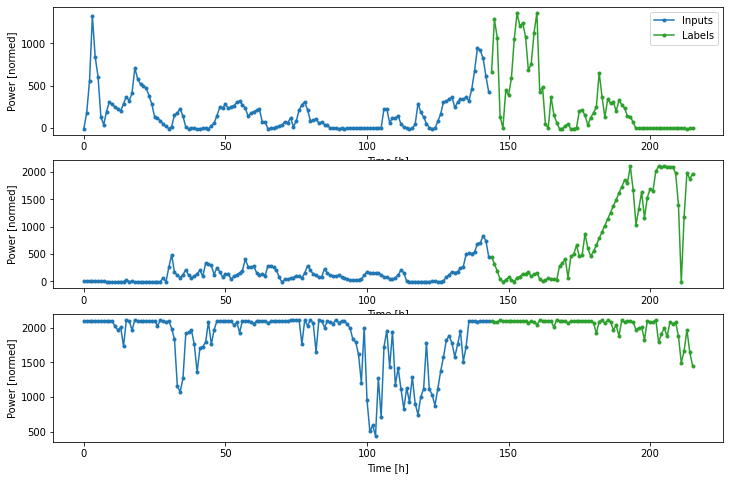

In [36]:
window.plot()

In [47]:
for inputs, labels in window.train.take(1):
    print(f'Inputs shape (batch, time, features): {inputs.shape}')
    print(f'Labels shape (batch, time, features): {labels.shape}')

Inputs shape (batch, time, features): (32, 144, 9)
Labels shape (batch, time, features): (32, 72, 1)


# LSTM_data_preproc

In [ ]:
raw_data = get_data(25)

In [ ]:
raw_data[13]

In [ ]:
data = clean_timesteps(raw_data)
data = clean_LSTM_data(data)

## clean_LSTM_data

In [ ]:
temp_data = data[0]

In [ ]:
index_with_nan = temp_data[temp_data.isna().any(axis=1) == True].index

In [ ]:
temp_data.loc[index_with_nan]

In [ ]:
temp_data.loc['2019-05-06 09:30':'2019-05-06 15:00']

In [ ]:
temp_data.loc['2019-05-06 09:30':'2019-05-06 15:00']

In [ ]:
for WTG_data in data:
    print(WTG_data.isna().sum().sum())
    WTG_data.interpolate(axis=0, inplace=True)
    print(WTG_data.isna().sum().sum())

##  split_LSTM_data

In [ ]:
temp = data[0]

In [ ]:
len(data[0])

In [ ]:
seq_len = int(24 * 6 * 5.5)
seq_len

In [ ]:
# Find number of seq possible
seq_num = len(data[0]) // (720+72) # per turbine
seq_num

In [ ]:
test_seq_len = int(0.2 * seq_num) # last 20% indices will belong to test set
val_seq_len  = int(0.2 * seq_num) # 2nd last 20% indices will belong to val set
test_seq_len, val_seq_len

In [ ]:
test_seq_start = seq_num - test_seq_len
val_seq_start = seq_num - test_seq_len - val_seq_len
0, val_seq_start, test_seq_start, 160

In [ ]:
test_idx_start = test_seq_start * seq_len
val_idx_start = val_seq_start * seq_len
val_idx_start, test_idx_start

In [ ]:
# Aggregated
test_idx_start = int((seq_num - (seq_num * 0.2)) * seq_len)
val_idx_start = int((seq_num - (seq_num * 0.4)) * seq_len)
val_idx_start, test_idx_start

In [ ]:
# Aggregated
seq_len = int(24 * 6 * 5.5)
seq_num = len(data[0]) // (720+72) # per turbine
test_idx_start = int(seq_num * (0.8 * seq_len))
val_idx_start = int(seq_num * (0.6 * seq_len))
val_idx_start, test_idx_start

In [ ]:
temp.iloc[val_idx_start:test_idx_start]

In [ ]:
# Test function
from projectwind.LSTM_preproc import split_train_val_test_split

In [ ]:
train, val, test = split_train_val_test_split(data, 5.5)

In [ ]:
train[0]

## get_sequence

In [ ]:
from projectwind.LSTM_preproc import get_sequences

In [ ]:
sequences = get_sequences(train, 5.5)

In [ ]:
sequences

## extract_target_from_sequences

In [ ]:
datasets = {'train':[1,2,3], 'val':[4,5], 'test':[6,7]}

In [ ]:
datasets = dict(train=[1,2,3], val=[4,5], test=[6,7])

In [ ]:
datasets

In [ ]:
for name, data in datasets.items():
    print(name)

In [ ]:
from projectwind.LSTM_preproc import extract_target_from_sequences

In [ ]:
sequences[0].shape[0]

In [ ]:
X, Y = extract_target_from_sequences(sequences, 0.5)

## init_LSTM_data

In [ ]:
from projectwind.LSTM_preproc import init_LSTM_data

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = init_LSTM_data(1, 5.5)

In [ ]:
len(X_train), len(X_val), len(X_test)

# Trainer_LSTM_model

In [ ]:
from projectwind.LSTM_preproc import init_LSTM_data, load_LSTM_data

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = init_LSTM_data(num_datasets=25, day_length=5.5)

In [ ]:
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_train.shape

In [ ]:
from projectwind.LSTM_model import init_LSTM_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization

In [ ]:
def init_LSTM_model(n_steps_in, n_steps_out, n_features):

    model = Sequential()
    model.add(BatchNormalization(input_shape=(n_steps_in, n_features)))
    model.add(LSTM(16, activation='tanh', return_sequences=True))
    model.add(LSTM(32, activation='tanh', return_sequences=False))
    model.add(Dense(n_steps_out, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=["mape"])

    return model

In [ ]:
model = init_LSTM_model(n_steps_in=X_train.shape[1], n_steps_out=y_train.shape[1], n_features=X_train.shape[2])

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val), 
                    #batch_size=1,
                    epochs=50,
                    callbacks=[es])

In [ ]:
from projectwind.trainer import plot_loss

In [ ]:
plot_loss(history)

## 